## hyao66: Assignment 4
### problem 1: Frozen Lake Problem with Policy Iteration, Value Iteration and Q learning

In [1]:
## reference: https://towardsdatascience.com/value-iteration-to-solve-openai-gyms-frozenlake-6c5e7bf0a64d
## frozen lake 8*8 grid problem

import numpy as np
import gym
import pygame
from gym import wrappers
import time
# from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
env_name  = 'FrozenLake8x8-v1'
env = gym.make(env_name)

# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3


# MAPS = {
#     "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
#     "8x8": [
#         "SFFFFFFF",
#         "FFFFFFFF",
#         "FFFHFFFF",
#         "FFFFFHFF",
#         "FFFHFFFF",
#         "FHHFFFHF",
#         "FHFFHFHF",
#         "FFFHFFFG",
#     ],
# }

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
nA = env.env.action_space.n
nS = env.env.observation_space.n
# print(nA)
# print(nS)


# obtain policy from given v
def get_policy_v(v, gamma = 1.0):
    policy = np.zeros(nS)  ## store action to be take for each state, the policy
    for s in range(nS):
        e = np.zeros(nA)
        for a in range(nA):
            q = 0
            P = np.array(env.env.P[s][a])
            (x,y) = np.shape(P)

            for i in range(x):
                s_ = int(P[i][1])
                p = P[i][0]
                r = P[i][2]

                q+= p*(r+gamma*v[s_])
                e[a]=q

        m = np.argmax(e)
        policy[s]=m
        
    return policy

# update value function given policy, compare with policy before update see if difference under threshold
def update_value_policy(v, policy, gamma = 1.0, threshold = 0.1):
#     v = np.zeros(nS)
#     prev_v = np.copy(v)
    
    while True:
        prev_v = np.copy(v)
        for s in range(nS):
            policy_s = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_s]])
        if (np.sum((np.fabs(prev_v - v))) <= threshold):
            # value converged
            break  
    return v


## combine get policy_v and update_value_policy to form policy iteration
def policy_iteration(max_iteration=1000, gamma = 1.0, threshold = 0.1):
    
    policy = np.random.choice(nA, size=(nS))  # initialize a random policy
    v = np.zeros(nS) ## initiate value with all zero
    
    for i in range(max_iteration):
        old_policy_v = update_value_policy(v, policy, gamma, threshold)
        new_policy = get_policy_v(old_policy_v, gamma)
        if (np.all(policy == new_policy)):
            print ('Policy-Iteration converged at iteration %d.' %(i+1))
            break
        policy = new_policy
    return policy, v, (i+1)


## value iteration
def value_iteration(max_iteration=1000, gamma = 1.0, threshold=0.1):
    v = np.zeros(nS)  # initialize value-function

    for i in range(max_iteration):
        prev_v = np.copy(v)
        for s in range(nS):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(nA)] 
            v[s] = max(q_sa)
        if (np.sum(np.fabs(prev_v - v)) <= threshold):
            print ('Value-iteration converged at iteration %d.' %(i+1))
            break
    return v, (i+1)


## calculate reward from policy
def run_episode(policy, gamma = 1.0, render = True):
    """ Runs an episode and return the total reward """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward


def evaluate_policy(policy, gamma = 1.0, n = 1000, render = True):
    scores = [run_episode(policy, gamma, render) for _ in range(n)]
    return scores


#https://towardsdatascience.com/reinforcement-learning-with-openai-d445c2c687d2

def Qlearner(gamma = 1.0, alpha = 0.8, episode = 100000, greedy=True):
    Q = np.zeros([nS, nA])  ## initiate q table
    # gamma = 1  #discount rate for reward
    # alpha = 0.8 # learning rate
    # episode = 100000
    reward_list = [] #record reward by episode

    for i in range(episode):
        s = env.reset()
        rAll=0
        j = 0
        d = False
        while j<99: ## allow for 100 steps per episode
    #         env.render()
            j+=1
            if greedy==True:
                a = np.argmax(Q[s,:] + np.random.randn(1,nA)*(1./(i+1))) #choose an action base on q table
            else:
                a = np.random.choice(nA)
            s1,r,d,_ = env.step(a) #Get new state & reward from environment
            Q[s,a] = Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]) - Q[s,a])
            rAll += (gamma ** j * r)
            s = s1
            if d == True:
                break
        reward_list.append(rAll)
    #     env.render()
#     policy = np.argmax(Q[state])
    total_reward = sum(reward_list)
    average_reward = total_reward/episode
#     print("Reward Sum on all episodes " + str(sum(reward_list)/episode))
#     print("Final Values Q-Table")
#     print(Q)


    return Q, total_reward, average_reward

In [4]:
np.random.seed(42)

optimal_policy, value, iteration = policy_iteration(max_iteration=1000, gamma = 1, threshold = 0.1)
optimal_value, iteration = value_iteration(max_iteration=1000, gamma = 1, threshold = 0.1)
optimal_policy_value = get_policy_v(optimal_value, gamma = 1)

Policy-Iteration converged at iteration 11.
Value-iteration converged at iteration 142.


###### Policy Iteration

([<matplotlib.axis.YTick at 0x7fb3b004b160>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

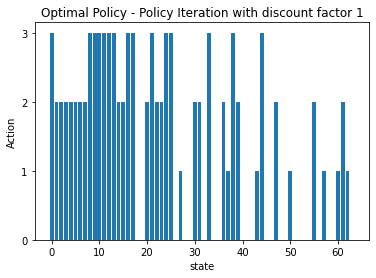

In [5]:
plt.figure()
plt.bar(x=np.arange(0,64, step=1), height=optimal_policy)
plt.ylabel('Action')
plt.title('Optimal Policy - Policy Iteration with discount factor 1')
plt.xlabel('state')
plt.yticks(np.arange(0,4, step=1))
# plt.xticks(np.arange(0,64, step=1))

In [6]:
np.unique(optimal_policy, return_counts=True)

(array([0., 1., 2., 3.]), array([23,  7, 19, 15]))

Policy-Iteration converged at iteration 11.
(array([0., 1., 2., 3.]), array([23,  7, 19, 15]))
Policy-Iteration converged at iteration 10.
(array([0., 1., 2., 3.]), array([20, 12, 19, 13]))
Policy-Iteration converged at iteration 12.
(array([0., 1., 2., 3.]), array([20, 12, 22, 10]))
Policy-Iteration converged at iteration 10.
(array([0., 1., 2., 3.]), array([20, 15, 21,  8]))
Policy-Iteration converged at iteration 11.
(array([0., 1., 2., 3.]), array([20, 15, 21,  8]))
Policy-Iteration converged at iteration 11.
(array([0., 1., 2., 3.]), array([20, 15, 21,  8]))
Policy-Iteration converged at iteration 10.
(array([0., 1., 2., 3.]), array([20, 15, 21,  8]))
Policy-Iteration converged at iteration 12.
(array([0., 1., 2., 3.]), array([20, 15, 21,  8]))
Policy-Iteration converged at iteration 11.
(array([0., 1., 2., 3.]), array([20, 16, 20,  8]))
Policy-Iteration converged at iteration 11.
(array([0., 1., 2., 3.]), array([20, 16, 20,  8]))
Policy-Iteration converged at iteration 13.
(array

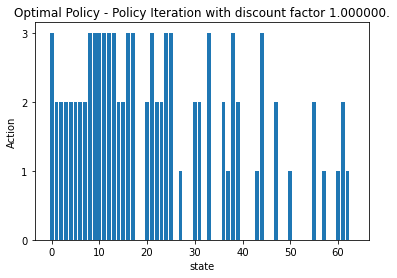

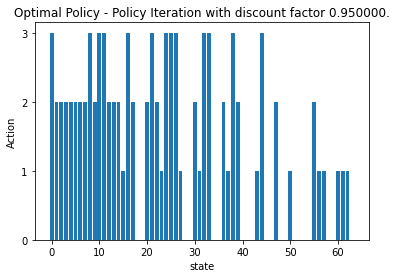

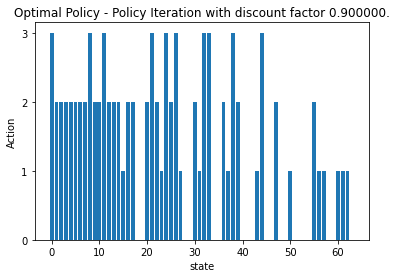

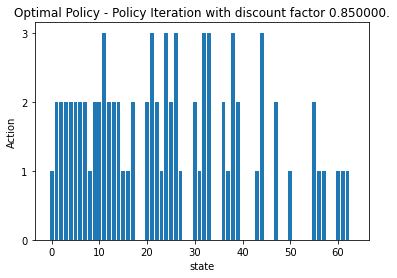

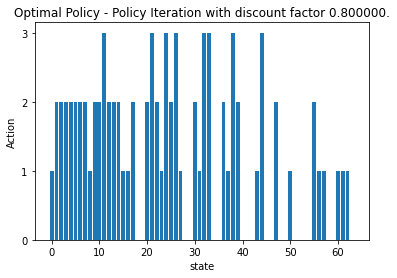

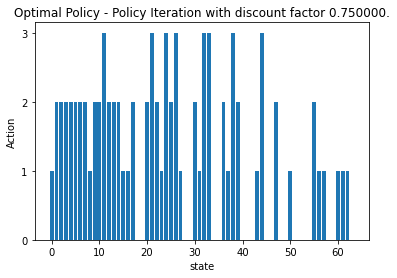

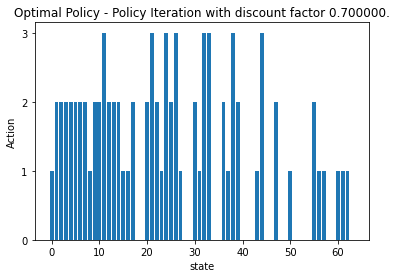

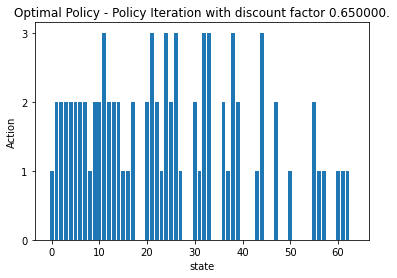

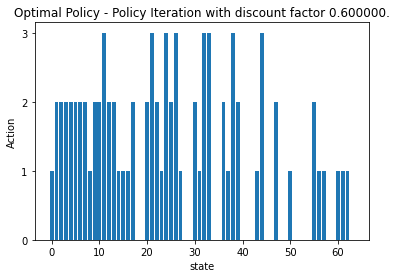

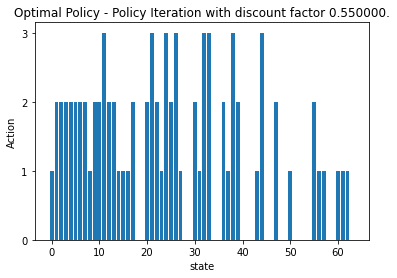

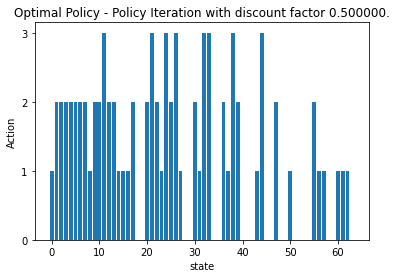

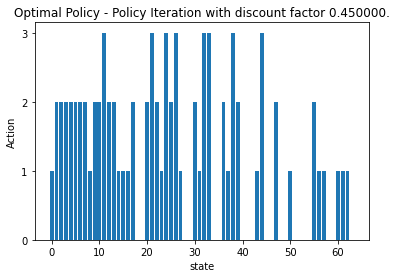

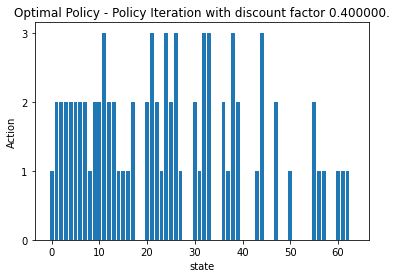

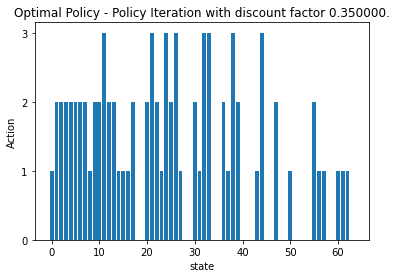

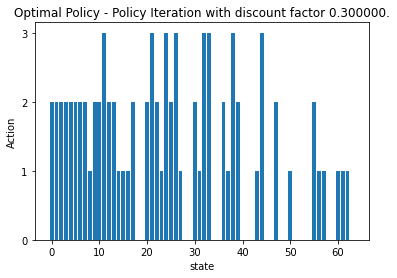

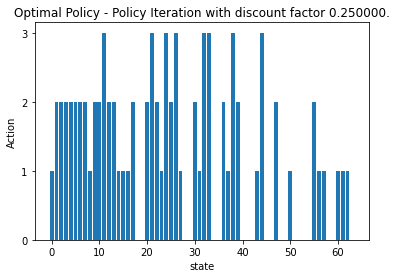

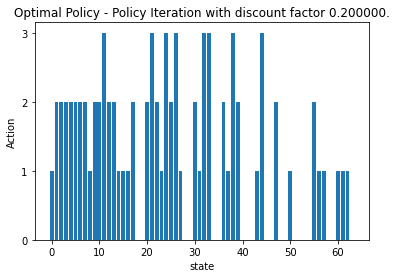

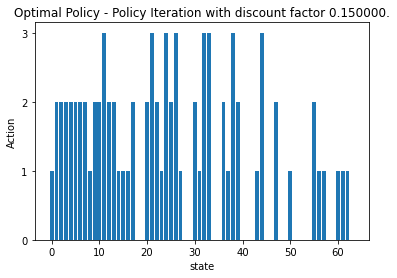

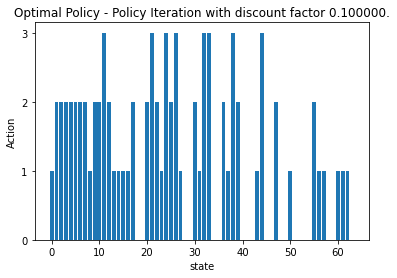

In [7]:
np.random.seed(42)

gamma = [1,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1]
duration = []
iteration = []
total_scores = []
average_scores = []
policy = []

for a_gamma in gamma:
    t1 = time.time()
    optimal_policy, _ , i = policy_iteration(max_iteration=1000, gamma = a_gamma, threshold = 0.1)
    t2 = time.time()
    run_time = t2-t1
    policy.append(optimal_policy)
    scores = evaluate_policy(optimal_policy, gamma = a_gamma, n = 1000, render = False)
    print(np.unique(optimal_policy, return_counts=True))
    
    plt.figure()
    plt.bar(x=np.arange(0,64, step=1), height=optimal_policy)
    plt.ylabel('Action')
    plt.title('Optimal Policy - Policy Iteration with discount factor %2f.' %(a_gamma))
    plt.xlabel('state')
    plt.yticks(np.arange(0,4, step=1))
    
    duration.append(run_time)
    iteration.append(i)
    total_scores.append(sum(scores))
    average_scores.append(np.mean(scores))

([<matplotlib.axis.XTick at 0x7fb3e1090970>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

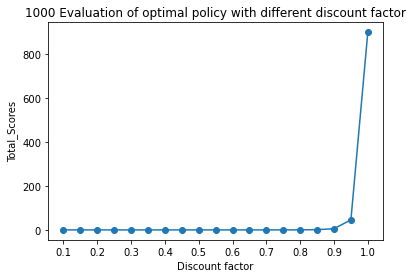

In [8]:
plt.figure()
plt.plot(gamma, total_scores, marker='o')
plt.ylabel('Total_Scores')
plt.title('1000 Evaluation of optimal policy with different discount factor')
plt.xlabel('Discount factor')
plt.xticks(np.arange(0.1,1.1, step=0.1))

([<matplotlib.axis.XTick at 0x7fb3f0580190>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

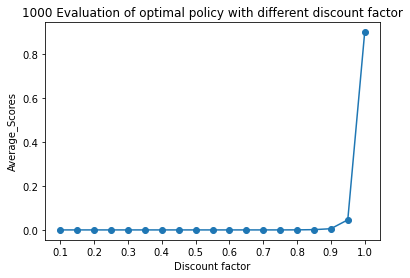

In [9]:
plt.figure()
plt.plot(gamma, average_scores, marker='o')
plt.ylabel('Average_Scores')
plt.title('1000 Evaluation of optimal policy with different discount factor')
plt.xlabel('Discount factor')
plt.xticks(np.arange(0.1,1.1, step=0.1))

([<matplotlib.axis.XTick at 0x7fb402f25790>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

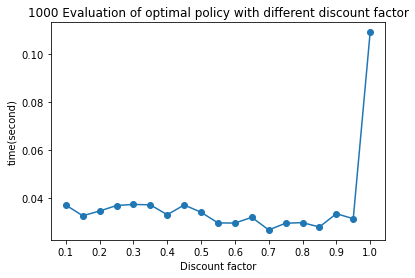

In [10]:
plt.figure()
plt.plot(gamma, duration, marker='o')
plt.ylabel('time(second)')
plt.title('1000 Evaluation of optimal policy with different discount factor')
plt.xlabel('Discount factor')
plt.xticks(np.arange(0.1,1.1, step=0.1))

###### Value Iteration

In [11]:
optimal_value, iteration = value_iteration(max_iteration=1000, gamma = 1, threshold = 0.1)
optimal_policy_value = get_policy_v(optimal_value, gamma = 1)

Value-iteration converged at iteration 142.


([<matplotlib.axis.YTick at 0x7fb3e121fca0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

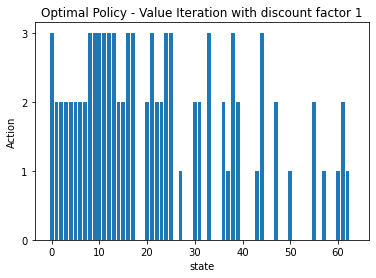

In [12]:
plt.figure()
plt.bar(x=np.arange(0,64, step=1), height=optimal_policy_value)
plt.ylabel('Action')
plt.title('Optimal Policy - Value Iteration with discount factor 1')
plt.xlabel('state')
plt.yticks(np.arange(0,4, step=1))
# plt.xticks(np.arange(0,64, step=1))

Value-iteration converged at iteration 142.
(array([0., 1., 2., 3.]), array([23,  7, 19, 15]))
Value-iteration converged at iteration 323.
(array([0., 1., 2., 3.]), array([27,  7, 18, 12]))
Value-iteration converged at iteration 493.
(array([0., 1., 2., 3.]), array([27,  7, 17, 13]))
Value-iteration converged at iteration 654.
(array([0., 1., 2., 3.]), array([27,  7, 17, 13]))


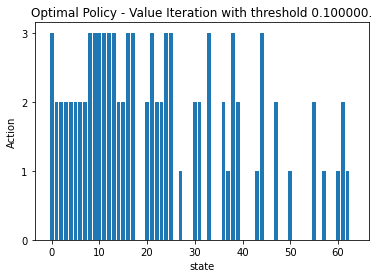

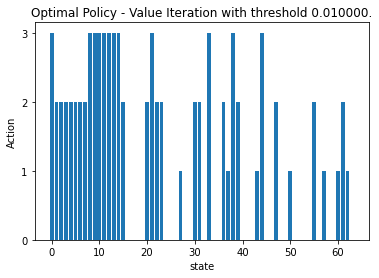

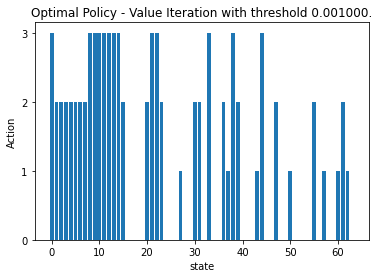

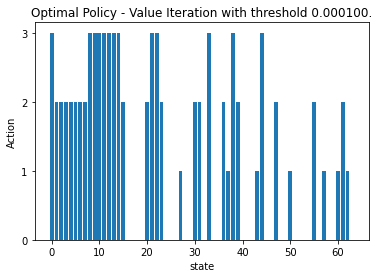

In [13]:
np.random.seed(42)

threshold = [0.1, 0.01, 0.001, 0.0001]
duration = []
iteration = []
total_scores = []
average_scores = []
policy = []

for a_threshold in threshold:
    t1 = time.time()
    
    optimal_value, i = value_iteration(max_iteration=1000, gamma = 1, threshold = a_threshold)
    optimal_policy_value = get_policy_v(optimal_value, gamma = 1)
    
    t2 = time.time()
    run_time = t2-t1
    policy.append(optimal_policy_value)
    scores = evaluate_policy(optimal_policy_value, gamma = 1, n = 1000, render = False)
    print(np.unique(optimal_policy_value, return_counts=True))
    
    plt.figure()
    plt.bar(x=np.arange(0,64, step=1), height=optimal_policy_value)
    plt.ylabel('Action')
    plt.title('Optimal Policy - Value Iteration with threshold %2f.' %(a_threshold))
    plt.xlabel('state')
    plt.yticks(np.arange(0,4, step=1))
    
    duration.append(run_time)
    iteration.append(i)
    total_scores.append(sum(scores))
    average_scores.append(np.mean(scores))

###### Q-learning

In [39]:
## take random action

# np.random.seed(42)

episode = [1000, 10000, 20000, 30000, 40000, 50000]
duration = []
# iteration = []
total_scores = []
average_scores = []
policy = []

for a_episode in episode:
    t1 = time.time()
    
    Q, total_reward, scores = Qlearner(gamma = 1.0, alpha = 0.8, episode = a_episode, greedy=False)
    Q_policy = [np.argmax(q) for q in Q] 
    
    t2 = time.time()
    run_time = t2-t1
    policy.append(Q_policy)
    scores = evaluate_policy(Q_policy, gamma = 1.0, n = 1000, render = False)
    print(np.unique(Q_policy, return_counts=True))
    
#     plt.figure()
#     plt.bar(x=np.arange(0,64, step=1), height=optimal_policy_value)
#     plt.ylabel('Action')
#     plt.title('Optimal Policy - Value Iteration with threshold %2f.' %(a_threshold))
#     plt.xlabel('state')
#     plt.yticks(np.arange(0,4, step=1))
    
    duration.append(run_time)
#     iteration.append(i)
    total_scores.append(sum(scores))
    average_scores.append(np.mean(scores))

(array([0, 2]), array([62,  2]))
(array([0, 1, 2, 3]), array([23, 12, 17, 12]))
(array([0, 1, 2, 3]), array([23,  9, 16, 16]))
(array([0, 1, 2, 3]), array([22,  8, 15, 19]))
(array([0, 1, 2, 3]), array([24,  6, 13, 21]))
(array([0, 1, 2, 3]), array([32,  7,  9, 16]))


In [43]:
## take episilon greedy

np.random.seed(42)

episode = [1000, 10000, 20000, 30000, 40000, 50000, 100000, 500000]
duration2 = []
# iteration = []
total_scores2 = []
average_scores2 = []
policy2 = []

for a_episode in episode:
    t1 = time.time()
    
    Q, total_reward, scores = Qlearner(gamma = 1.0, alpha = 0.8, episode = a_episode, greedy=True)
    Q_policy = [np.argmax(q) for q in Q] 
    
    t2 = time.time()
    run_time = t2-t1
    policy2.append(Q_policy)
    scores = evaluate_policy(Q_policy, gamma = 1.0, n = 1000, render = False)
    print(np.unique(Q_policy, return_counts=True))
    
#     plt.figure()
#     plt.bar(x=np.arange(0,64, step=1), height=optimal_policy_value)
#     plt.ylabel('Action')
#     plt.title('Optimal Policy - Value Iteration with threshold %2f.' %(a_threshold))
#     plt.xlabel('state')
#     plt.yticks(np.arange(0,4, step=1))
    
    duration2.append(run_time)
#     iteration.append(i)
    total_scores2.append(sum(scores))
    average_scores2.append(np.mean(scores))

(array([0]), array([64]))
(array([0, 1, 2, 3]), array([20,  8, 13, 23]))
(array([0, 1, 2, 3]), array([22,  9, 16, 17]))
(array([0, 1, 2, 3]), array([24, 12, 16, 12]))
(array([0, 1, 2, 3]), array([24,  7, 12, 21]))
(array([0, 1, 2, 3]), array([22, 13, 15, 14]))
(array([0, 1, 2, 3]), array([25, 10, 12, 17]))
(array([0, 1, 2, 3]), array([20,  9, 14, 21]))


In [40]:
total_scores

[0.0, 403.0, 774.0, 380.0, 820.0, 30.0]

In [44]:
total_scores2

[0.0, 681.0, 503.0, 293.0, 196.0, 556.0, 461.0, 472.0]

In [41]:
duration

[0.5375969409942627,
 5.101315259933472,
 10.204708099365234,
 15.450934886932373,
 20.663416147232056,
 25.88218116760254]

In [42]:
duration2

[0.7662200927734375,
 17.054969310760498,
 26.702030181884766,
 45.582112073898315,
 58.56883692741394,
 74.70626211166382]

In [47]:
learning_rate = [0.99, 0.9, 0.85, 0.8, 0.75, 0.7]
duration = []
# iteration = []
total_scores = []
average_scores = []
policy = []

for a_learn in learning_rate:
    t1 = time.time()
    
    Q, total_reward, scores = Qlearner(gamma = 1.0, alpha = a_learn, episode = 40000, greedy=True)
    Q_policy = [np.argmax(q) for q in Q] 
    
    t2 = time.time()
    run_time = t2-t1
    policy.append(Q_policy)
    scores = evaluate_policy(Q_policy, gamma = 1.0, n = 1000, render = False)
    print(np.unique(Q_policy, return_counts=True))
    
#     plt.figure()
#     plt.bar(x=np.arange(0,64, step=1), height=optimal_policy_value)
#     plt.ylabel('Action')
#     plt.title('Optimal Policy - Value Iteration with threshold %2f.' %(a_threshold))
#     plt.xlabel('state')
#     plt.yticks(np.arange(0,4, step=1))
    
    duration.append(run_time)
#     iteration.append(i)
    total_scores.append(sum(scores))
    average_scores.append(np.mean(scores))

(array([0, 1, 2, 3]), array([40,  3,  5, 16]))
(array([0, 1, 2, 3]), array([26,  4, 16, 18]))
(array([0, 1, 2, 3]), array([21,  9, 13, 21]))
(array([0, 1, 2, 3]), array([25, 11, 15, 13]))
(array([0, 1, 2, 3]), array([23,  5, 18, 18]))
(array([0, 1, 2, 3]), array([21, 10, 18, 15]))


In [49]:
total_scores

[0.0, 279.0, 279.0, 356.0, 266.0, 462.0]

In [16]:
Q, total_reward, scores = Qlearner(gamma = 1.0, alpha = 0.8, episode = 10000, greedy=False)

In [17]:
Q_policy = [np.argmax(q) for q in Q] 

In [18]:
scores = evaluate_policy(policy[3], gamma = 1.0, n = 1000, render = False)
print(np.sum(scores))

###### My Test

In [ ]:
np.array(Q_policy)

In [ ]:
scores = evaluate_policy(np.array(Q_policy), gamma = 1, render = False)
print(np.mean(scores))

In [ ]:
scores = evaluate_policy(optimal_policy_value, gamma = 1, render = False)
print(np.mean(scores))

In [ ]:
Q, total_reward, scores = Qlearner(gamma = 1.0, alpha = 0.8, episode = 100000, greedy=True)

In [ ]:
print(scores)

In [ ]:
observation = env.reset()
for i in range(len(optimal_policy)):
    env.render()
    a = int(optimal_policy[i])
#     print(a)
    observation, reward, done, info  = env.step(a)
#     print observation, reward, done, info

In [ ]:
observation = env.reset()

In [ ]:
#https://towardsdatascience.com/reinforcement-learning-with-openai-d445c2c687d2
Q = np.zeros([nS, nA])  ## initiate q table

gamma = 1  #discount rate for reward
alpha = 0.8 # learning rate
episode = 100000
reward_list = [] #record reward by episode

for i in range(episode):
    s = env.reset()
    rAll=0
    j = 0
    d = False
    while j<99:
        env.render()
        j+=1
        a = np.argmax(Q[s,:] + np.random.randn(1,nA)*(1./(i+1))) #choose an action base on q table
        s1,r,d,_ = env.step(a) #Get new state & reward from environment
        Q[s,a] = Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    reward_list.append(rAll)
    env.render()
    
# print("Reward Sum on all episodes " + str(sum(reward_list)/episode))
# print("Final Values Q-Table")
# print(Q)
            

In [ ]:
np.random.randn(1,nA)

In [ ]:
Q = np.zeros([nS, nA])

In [ ]:
Q[0,:]

In [ ]:
m = np.random.randn(1,nA)

In [ ]:
np.argmax(Q[0,:] + m*(1./(1+1)))

In [ ]:
m

In [ ]:
np.random.choice(nA)